# Прирост (убыль) населения по регионам России
Рассмотрим величины изменения численности населения регионов России за 2017-й год и попробуем выразить эту величину формульно относительно других переменных.

# Задание 1.

In [300]:
import numpy as np
import pandas as pd
from sklearn.linear_model import LinearRegression
import statsmodels.api as sm
import patsy as pt
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

Будем строить линейную регрессию целевой переменной (difference) по следующим переменным:
1. salary – медианная ЗП в регионе
    Учащиеся, либо уже взрослые люди имеют тенденцию переезжать в города с более высоким уровнем ЗП, поэтому логично использовать данное соображение в модели.
2. c_resource – ресурсы домашних хозяйств в городской местности в среднем на члена домашнего хозяйства в месяц
3. r_resource – ресурсы домашних хозяйств в сельской местности в среднем на члена домашнего хозяйства в месяц
    Пункты 2 и 3, предположительно, включают в себя оценку тенденции семей в регионе к большему либо меньшему числу детей, а также дают разделение на индустриальную и сельскую часть региона. Есть вероятность, что данные величины будут сильно коррелированы с salary, на это стоит обратить особое внимание. Возможно, в дальнейшем данные переменные целесообразно использовать комбинированно вместе с другими параметрами, как например, население в регионе, и др.
4. bars – количество баров в крупнейшем городе региона
    Мотивацией для переселения между регионами может служить не только материальное положение жителей, но и "разнообразие досуга", которое, за неимением какого-то конкретного показателя, я решил попробовать выразить в количестве баров в крупнейшем городе региона.
5. bar_per_human – количество баров на тысячу жителей в крупнейшем городе региона
    В качестве бонусного параметра дано количество баров на тысячу жителей в крупнейшем городе региона – альтернатива переменной bars для поиска более подходящей переменной.

In [330]:
dirty_data = pd.read_csv('data.csv', sep=';')
variables = list(dirty_data.columns[1:6])+list(dirty_data.columns[7:8])
data = dirty_data[variables]
data = data.iloc[:-1, :]
data.head()

,difference,salary,c_resource,r_resource,bars,bar_per_human
0,-832.00,25448.0,29330.7,24776.3,63.0,0.16
1,-3865.01,20232.0,17281.7,15847.0,92.0,0.23
2,-4304.00,23449.0,26140.0,17577.5,48.0,0.13
3,-11.00,23440.0,25674.4,20573.2,128.0,0.12
4,-2666.00,19001.0,24275.4,20302.1,100.0,0.25


Начнем работу с данными.

Сразу видно, что различные признаки имеют различный масштаб. Насколько я знаю, хотя в случае с некоторыми моделями это может негативно сказываться на качестве модели, при работе с линейной регрессией в этом нет проблемы, поэтому можно не масштабировать вещественные признаки.
Вместо этого посмотрим для начала на попарные зависимости признаков друг от друга.

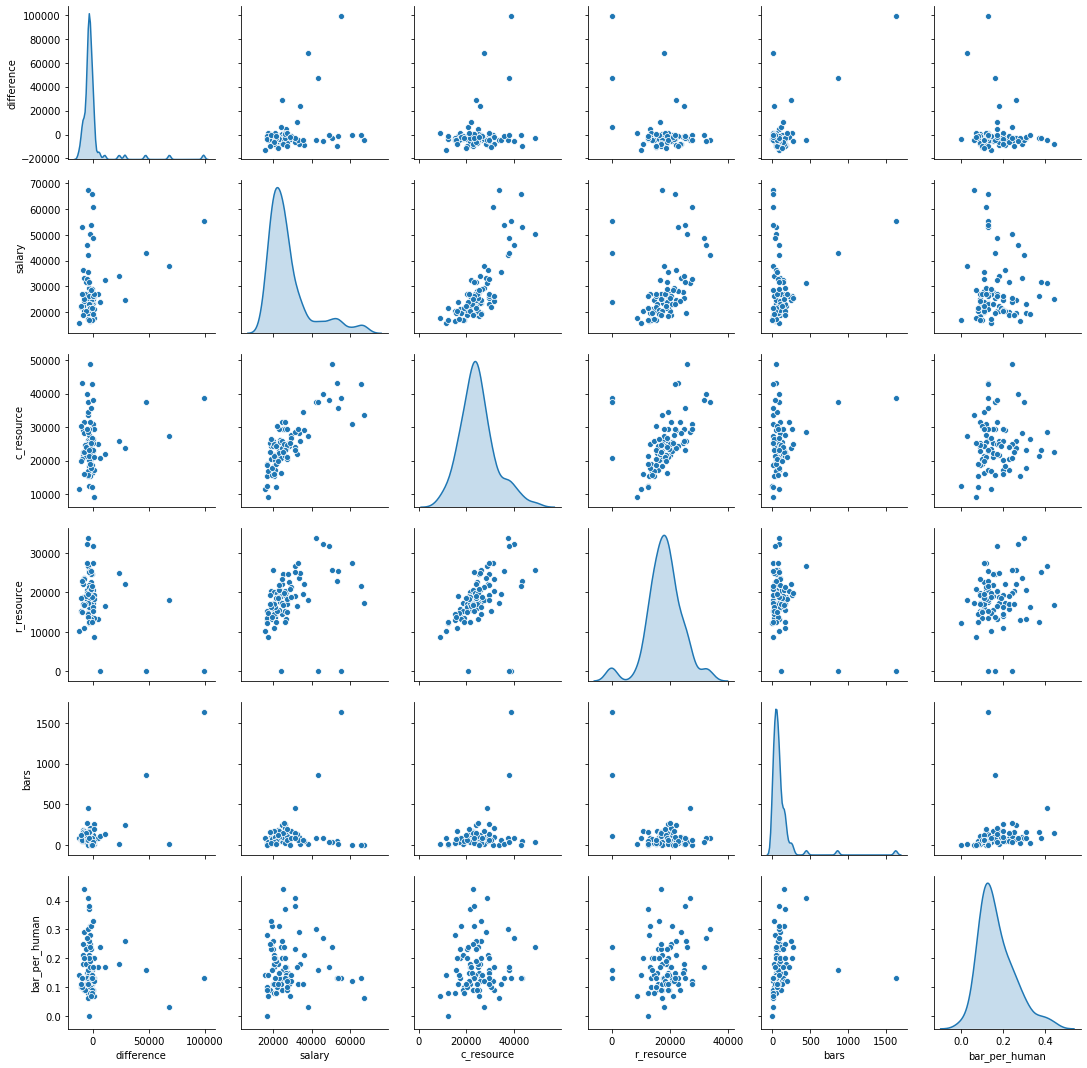

In [331]:
g = sns.pairplot(data, diag_kind="kde")

Рассмотрим диагональные гистограммы распределения объектов. В разрезе целевой переменной difference, а также в разрезе признака bars видны выбросы, которые, возможно могут повлиять на дальнейшую работу. Выясним, что это за точки. 

In [332]:
diffsort_data = dirty_data.sort_values(by='difference', ascending=False)
diffsort_data[dirty_data.columns[:-1]].head(7)

,region,difference,salary,c_resource,r_resource,bars,people,bar_per_human
17,Город Москва столица Российской Федерации горо...,98717.99,55434.0,38805.8,0.0,1633.0,12678.0,0.13
9,Московская область,68262.99,38074.0,27412.0,17957.8,14.0,507.0,0.03
28,Город Санкт-Петербург город федерального значения,46977.00,43136.0,37640.8,0.0,863.0,5398.0,0.16
32,Краснодарский край,28573.00,24875.0,23887.6,22191.7,242.0,933.0,0.26
24,Ленинградская область,23463.00,34205.0,25919.9,24882.5,17.0,92.0,0.18
62,Тюменская область (кроме Ханты-Мансийского авт...,10475.99,32366.0,21965.7,16567.5,138.0,807.0,0.17
36,Город федерального значения Севастополь,5942.00,24080.0,20667.0,0.0,108.0,449.0,0.24


In [333]:
barsort_data = dirty_data.sort_values(by='bars', ascending=False)
barsort_data[dirty_data.columns[:-1]].head()

,region,difference,salary,c_resource,r_resource,bars,people,bar_per_human
17,Город Москва столица Российской Федерации горо...,98717.99,55434.0,38805.8,0.0,1633.0,12678.0,0.13
28,Город Санкт-Петербург город федерального значения,46977.00,43136.0,37640.8,0.0,863.0,5398.0,0.16
70,Красноярский край,-4465.00,31321.0,28667.0,26807.7,451.0,1094.0,0.41
55,Самарская область,-5357.00,25483.0,24944.4,19879.8,275.0,1157.0,0.24
47,Республика Татарстан (Татарстан),1099.00,26092.0,29558.6,19409.5,256.0,1257.0,0.20


Для однородности данных избавимся от выбросов. Таковыми решено было выбрать 5 точек с максимальным значением difference и 2 точки с максимальным значением bars.
Видно, что второе множество входит в первое, поэтому теперь можно просто удалить 5 точек с максимальным значением difference.

In [229]:
diffdel = list(diffsort_data.iloc[0:5, 0])
indexesdel = [dirty_data[dirty_data['region'] == x].index[0] for x in diffdel]
pure_data = diffsort_data.drop(indexesdel, axis='index')[variables]
pure_data =  pure_data.drop([85], axis='index')

/Users/Dima/anaconda3/lib/python3.7/site-packages/statsmodels/nonparametric/kde.py:444: RuntimeWarning: invalid value encountered in greater
  X = X[np.logical_and(X > clip[0], X < clip[1])] # will not work for two columns.
/Users/Dima/anaconda3/lib/python3.7/site-packages/statsmodels/nonparametric/kde.py:444: RuntimeWarning: invalid value encountered in less
  X = X[np.logical_and(X > clip[0], X < clip[1])] # will not work for two columns.


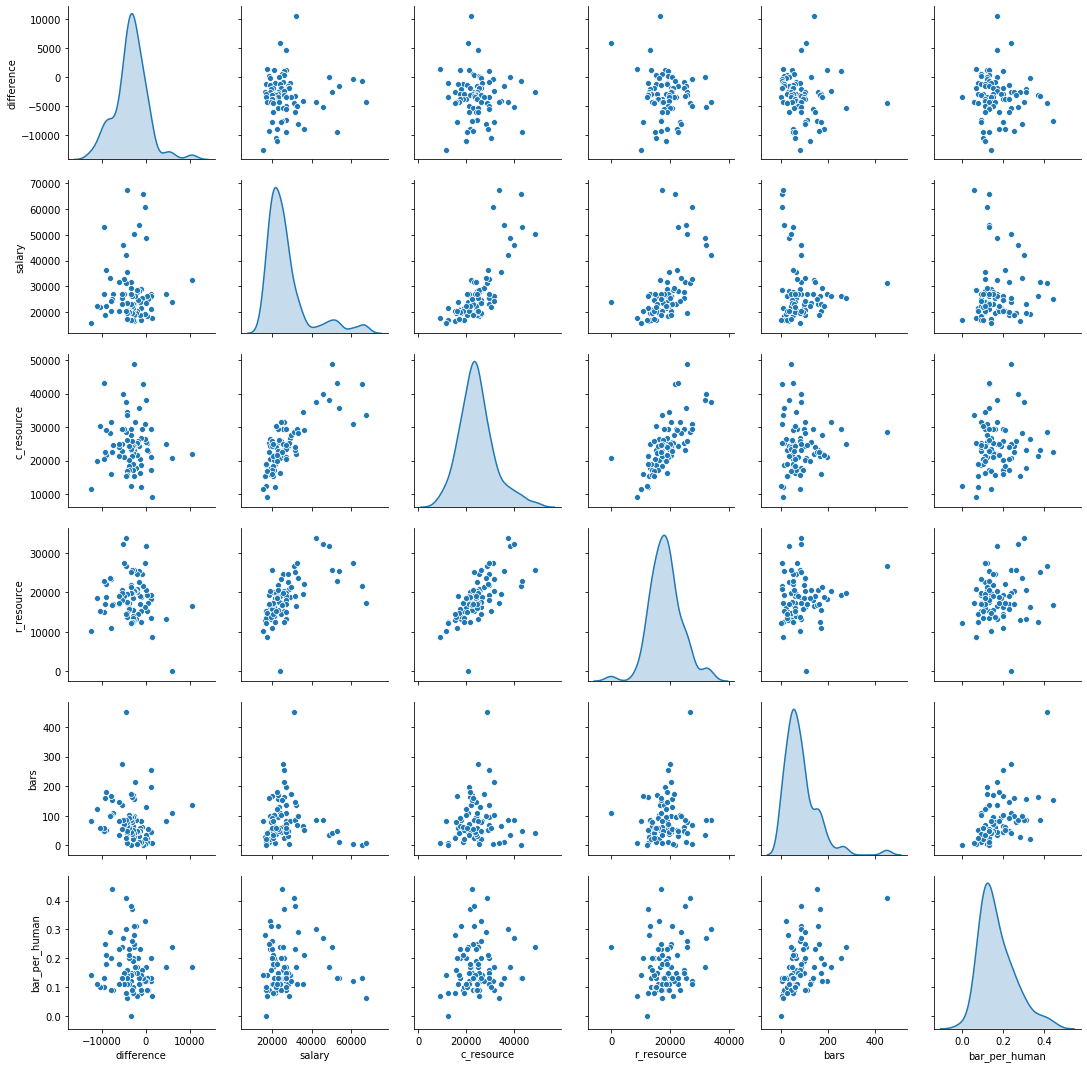

In [221]:
g = sns.pairplot(pure_data, diag_kind="kde")

Как видно, теперь и гистограммы распределения признаков, и диаграммы поппарных распределений признаков содержат меньше выбивающихся из общей конвы точек.

Тем не менее, судя по точечным диаграммам, целевая переменная difference не имеет с представленными признаками явной взаимосвязи. Можно предположить, что качество модели с такими признаками получится неудовлетворительным.

In [334]:
#print('Отдельно посчитаны корреляции всех признаков с целевым - difference\n')
#print(pure_data[pure_data.columns[1:]].corrwith(pure_data[pure_data.columns[:1][0]]), '\n')
#
#print('Тепловая карта всех попарных корреляций признаков')
#corr_matrix = pure_data.corr()
#sns.heatmap(corr_matrix, linewidths=.5, annot = True)

In [335]:
data1 = pure_data.drop(pure_data.columns[2:4], axis='columns')
data1['resource'] = list(x+y for x, y in zip(pure_data['c_resource'], pure_data['r_resource']))

In [336]:
#corr_matrix = data1.corr()
#sns.heatmap(corr_matrix, linewidths=.5, annot = True)
#data1[data1.columns[1:]].corrwith(data1[data1.columns[:1][0]])

In [352]:
X = pure_data.drop(pure_data.columns[0], axis='columns')
y = pure_data['difference']
model = LinearRegression()
model.fit(X, y)
#X = np.hstack((np.ones((np.shape(X)[0], 1)), X))

coeffs = list()
coeffs.append(model.intercept_)
coeffs.extend(model.coef_)

print('Полученные коэффициенты модели:\n')
print('intercept : ', coeffs[0])
for item in zip(pure_data.columns[1:], coeffs[1:]):
    print(item[0], ' : ', item[1])


Полученные коэффициенты модели:

intercept :  -1836.6535533908168
salary  :  0.05902431945249671
c_resource  :  -0.024218625322644266
r_resource  :  -0.1261473491471386
bars  :  -5.02430706100069
bar_per_human  :  1558.332412456372


In [353]:
def linear_prediction(X, w):
    Xx = np.hstack((np.ones((np.shape(X)[0], 1)), X))
    return Xx.dot(w)
def mserror(y, y_pred):
    return sum((y - y_pred)**2)/len(y)

RSS = mserror(y, linear_prediction(X, coeffs))
TSS = np.var(y)

r2 = 1 - RSS/TSS
print('r2 = ', r2)

r2 =  0.04338772837024496


Как и предполагалось выше, коэффициент детерминации получился слишком низким, чтобы можно было назвать данную модель рабочей.

Из этого делаем вывод, что при дальнейшей работе с ней следует найти новые признаки, новые данные, с которыми целевая переменная, возможно, будет взаимозависима лучше.


# Задание 2.

Построим доверительный интервал для оценки коэффициента при переменной bars.

Для этого сначала построим регрессию, пользуясь статистическим аппаратом, с помощью которого можно сразу получить матрицу ковариаций для оценок коэффициентов регрессии.

In [339]:
import statsmodels.api as sm

model = sm.OLS(y,X)
results = model.fit()

coeffs = results.params
print(coeffs)

cov_matrix = results.normalized_cov_params
cov_matrix

const   -1836.653553
x1          0.059024
x2         -0.024219
x3         -0.126147
x4         -5.024307
x5       1558.332412
dtype: float64


,const,x1,x2,x3,x4,x5
const,2.116255e-01,-1.174026e-07,-3.149665e-06,-4.312069e-06,-5.136590e-05,-0.199120
x1,-1.174026e-07,2.786906e-10,-3.206393e-10,-1.669741e-11,5.913710e-09,0.000001
x2,-3.149665e-06,-3.206393e-10,8.458752e-10,-4.389275e-10,-5.619499e-09,-0.000001
x3,-4.312069e-06,-1.669741e-11,-4.389275e-10,8.882941e-10,-1.854656e-09,-0.000005
x4,-5.136590e-05,5.913710e-09,-5.619499e-09,-1.854656e-09,3.313519e-06,-0.001268
x5,-1.991198e-01,1.127566e-06,-1.236681e-06,-4.859316e-06,-1.268247e-03,2.309038


In [340]:
alpha = 0.05

se = (cov_matrix.iloc[4,4])**0.5
bound = se * stats.t.ppf(1-alpha/2., pure_data.shape[0]-6)

print('Доверительный интервал для коэффициента при bars:\t', round(coeffs[4] - bound, 3), '\t', round(coeffs[4] + bound, 3))


Доверительный интервал для коэффициента при bars:	 -5.028 	 -5.021


Таким образом, выполнен и следующий пункт задания – гипотеза о том, что данный коэффициент равен нулю отвергается на уровне значимости 0.05.

Потсроим теперь доверительный интервал для дисперсии.

In [346]:
alpha = 0.05

bound = list()
se = RSS*len(y)/(len(y)-1)
bound.append(se*(len(y)-1)/stats.chi2.ppf(1-alpha/2., pure_data.shape[0]-6))
bound.append(se*(len(y)-1)/stats.chi2.ppf(alpha/2., pure_data.shape[0]-6))

print('Доверительный интервал для дисперсии:\t', round(bound[0], 3), '\t', round(bound[1], 3))

Доверительный интервал для дисперсии:	 10357133.609 	 19814317.1
